# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
$ M(X) = -5 \cdot 0.4 + 2 \cdot 0.3 + 3 \cdot 0.1 + 4 \cdot 0.2 = -0.3 $

SyntaxError: invalid syntax (<ipython-input-1-9178d35ee0e6>, line 1)

$ M(X^{2}) = 25 \cdot 0.4 + 4 \cdot 0.3 + 9 \cdot 0.1 + 16 \cdot 0.2 = 15.3 $

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-02-11 12:05:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [                <=> ] 201.24M  60.1MB/s    in 3.6s    

2024-02-11 12:05:39 (55.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
df.isna().sum().sum()

0

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
scaler = StandardScaler()
X = df.iloc[:, 1:].values
X_scaled = scaler.fit_transform(X)
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
X_test = X[train_size:, :]

y_train = y[:train_size]
y_test = y[train_size:]


X_train_scaled = X_scaled[:train_size, :]
X_test_scaled = X_scaled[train_size:, :]

In [ ]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = ...

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset = TensorDataset(torch.Tensor(X_train_scaled),torch.Tensor(y_train)) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True) # create your dataloader

val_dataset = TensorDataset(torch.Tensor(X_test_scaled),torch.Tensor(y_test)) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False) # create your dataloader

In [ ]:
def linear_model(train_dataloader, val_dataloader, lr=.05, n_epochs=10):
  w = torch.rand(90, requires_grad=True)
  b = torch.rand(1, requires_grad=True)

  for epoch in range(n_epochs):

    for x_train, y_train in tqdm(train_dataloader):

      y_pred = torch.matmul(x_train, w)  + b
      loss = torch.sqrt(torch.mean((y_pred - y_train) ** 2))
      loss.backward()

      w.data -= lr * w.grad
      b.data -= lr * b.grad

      # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
      w.grad.data.zero_()
      b.grad.data.zero_()


    val_loss = []

    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          y_pred = torch.matmul(x_val, w)  + b
          loss = torch.sqrt(torch.mean((y_pred - y_val) ** 2))
          val_loss.append(loss.numpy())
    print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}")

    # рисуем картинки

    # clear_output(True)
    # plt.figure(figsize=(10, 8))
    # plt.scatter(y.data.numpy(), label="data")
    # plt.scatter(
    #     x.data.numpy(),
    #     y_pred.data.numpy(),
    #     color="orange",
    #     linewidth=5,
    #     label="predictions",
    # )
    # plt.xlabel("LSTAT", fontsize=14)
    # plt.ylabel("MEDV (target)", fontsize=14)
    # plt.title("Boston modelling", fontsize=18)
    # plt.legend(fontsize=14)
    # plt.show()

    # print("loss = ", loss.data.numpy())
    # if loss.data.numpy() < 0.1:
    #     print("Done!")
    #     break

  return w, b



In [ ]:
w, b = linear_model(train_dataloader, val_dataloader, lr=0.05)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [ ]:
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, n_epochs=10):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):

        # тренировка
        test_epoch_losses = []
        model = model.train()
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train)
            # loss = torch.sqrt(torch.mean((y_pred - y_train) ** 2))
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            test_epoch_losses.append(loss.detach().item())
            train_losses.append(loss.detach().item())

        if scheduler:
            scheduler.step()

        val_epoch_losses = []
        model.eval()
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader):
              y_pred = model(x_val)
              y_pred = torch.from_numpy(scaler_2.inverse_transform(y_pred.detach().numpy()).reshape(1,-1)[0])
              loss = criterion(y_pred, y_val)
              val_epoch_losses.append(loss.detach().item())


        val_losses.append(np.mean(val_epoch_losses))
        clear_output()
        # plot_history(train_losses, val_losses, "loss")
        print(optimizer.defaults['lr'])
        print(optimizer.param_groups[0]['lr'])
        print("Train loss:", np.mean(test_epoch_losses))
        print("Val loss:", np.mean(val_epoch_losses))

    return np.mean(val_epoch_losses)



def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = model(x_train)

    loss = criterion(y_pred, y_train)

    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

scaler_2 = PowerTransformer(method='yeo-johnson')

# y_train_tr = pt.fit_transform(y_train.reshape(-1, 1))
# y_test_tr = pt.transform(y_test.reshape(-1, 1))

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
atrain_sample = 200_000
test_sample = 30_000
val_sample = 200_000
batch_size = 64


index_train = np.random.choice(df.index, train_sample, replace=False)
index_test = np.random.choice(df[~df.index.isin(index_train)].index, test_sample, replace=False)
index_val = np.random.choice(df[~df.index.isin(np.concatenate([index_train,index_test], axis=0) )].index, val_sample, replace=False)

X_train = X[index_train]
y_train = y[index_train]
X_test = X[index_test]
y_test = y[index_test]
X_val = X[index_val]
y_val = y[index_val]


scaler_1 = StandardScaler()
scaler_1.fit(X)
X_scaled = scaler_1.transform(X)

# scaler_2 = StandardScaler()
scaler_2.fit(y.reshape(-1, 1))
y_scaled = scaler_2.transform(y.reshape(-1, 1))

X_train = X[index_train]
X_test = X[index_test]

y_scaled_train = y_scaled[index_train].ravel()
y_scaled_test = y_scaled[index_test].ravel()
y_scaled_val = y_scaled[index_val].ravel()

X_train_scaled = X_scaled[index_train]
X_test_scaled = X_scaled[index_test]
X_val_scaled = X_scaled[index_val]

train_set = TensorDataset(torch.Tensor(X_train_scaled),torch.Tensor(y_scaled_train))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.Tensor(X_test_scaled),torch.Tensor(y_test))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

val_set = TensorDataset(torch.Tensor(X_val_scaled),torch.Tensor(y_val))
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [ ]:
def test_train_loader(batch_size):
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [ ]:
model = nn.Sequential(
    nn.Dropout(p=0.2),
    # nn.Linear(90, 30),
    nn.LeakyReLU(),
    nn.Linear(90, 1)
    )
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1
    )
lambda_func = lambda epoch: 0.7**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [ ]:
def rmse_loss(prediction, target):
  loss_fn = nn.MSELoss()
  return torch.sqrt(loss_fn(prediction, target))

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective(trial, n_epochs=10):

  p = trial.suggest_loguniform("dropout", 0.1, 1)

  model = nn.Sequential(
    nn.Dropout(p=p),
    nn.Linear(90, 30),
    nn.LeakyReLU(),
    nn.Linear(30, 1)
  )
  batch_size = trial.suggest_int('batch_size', 32, 64, step=32)
  train_loader, test_loader = test_train_loader(batch_size)

  # weight_decay=trial.suggest_float("weight_decay", 1e-13, 0.1, log=True)

  # optimizer = torch.optim.SGD(
  #     model.parameters(),
  #     lr=lr,
  #     momentum=momentum,
  #     # weight_decay=weight_decay
  # )

  optimizer_name = trial.suggest_categorical('optimizer',
   ['Adam', 'SGD', 'RMSprop', 'Rprop', 'RAdam', 'Adagrad', 'AdamW'])

  # Sample hyperparameters based on the chosen optimizer
  lr = trial.suggest_loguniform(f'{optimizer_name.lower()}_lr', 1e-5, 1)



  optimizer_class = getattr(torch.optim, optimizer_name)
  optimizer_args = {'lr': lr}

  if optimizer_name == 'SGD':
      momentum = trial.suggest_loguniform('sgd_momentum', 0.01, 1)
      optimizer_args['momentum'] = momentum
  elif optimizer_name == 'RMSprop':
      alpha = trial.suggest_loguniform('rmsprop_alpha', 0.01, 1)
      optimizer_args['alpha'] = alpha

  optimizer = optimizer_class(model.parameters(), **optimizer_args)

  lambda_func = lambda epoch: 0.8**epoch

  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

  return train(model, optimizer, scheduler, rmse_loss, train_loader, test_loader, n_epochs=n_epochs)


In [ ]:
sampler = optuna.samplers.RandomSampler()
pruner=optuna.pruners.MedianPruner(n_startup_trials=1, n_warmup_steps=2, interval_steps=2)
study = optuna.create_study(directions=["minimize"], sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=10)

1.0575152128519796e-05
6.768097362252671e-06
Train loss: 0.9936486406803131
Val loss: inf


  0%|          | 0/6250 [00:00<?, ?it/s]

[W 2024-02-11 12:08:44,166] Trial 0 failed with parameters: {'dropout': 0.10125757871276565, 'batch_size': 32, 'optimizer': 'RMSprop', 'rmsprop_lr': 1.0575152128519796e-05, 'rmsprop_alpha': 0.05284715356892964} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-25-8b649193f79f>", line 47, in objective
    return train(model, optimizer, scheduler, rmse_loss, train_loader, test_loader, n_epochs=n_epochs)
  File "<ipython-input-16-a5b001b247b9>", line 19, in train
    for x_train, y_train in tqdm(train_loader):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 249, in __iter__
    for obj in it:
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1182, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloade

KeyboardInterrupt: 

In [ ]:
# Получение наилучших гиперпараметров
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'dropout': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'SGD', 'sgd_lr': 0.025283133522411735, 'sgd_momentum': 0.3108662547617582}


In [ ]:
study.best_value

10.67793528103371

In [ ]:
inversed = scaler.inverse_transform(y_scaled)

In [ ]:
import torch
import torch.optim as optim
import optuna

# Define your model, dataset, and other constants here

def objective(trial):
    # Sample optimizer type using Optuna
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Sample hyperparameters based on the chosen optimizer
    lr = trial.suggest_loguniform(f'{optimizer_name.lower()}_lr', 1e-5, 1e-1)

    # Use getattr to dynamically access the optimizer class based on the name
    optimizer_class = getattr(optim, optimizer_name)
    optimizer_args = {'lr': lr}

    if optimizer_name == 'SGD':
        momentum = trial.suggest_uniform('sgd_momentum', 0.0, 1.0)
        optimizer_args['momentum'] = momentum
    elif optimizer_name == 'RMSprop':
        alpha = trial.suggest_uniform('rmsprop_alpha', 0.0, 1.0)
        optimizer_args['alpha'] = alpha

    optimizer = optimizer_class(model.parameters(), **optimizer_args)

    # Training loop with your model, dataset, and optimizer
    for epoch in range(num_epochs):
        # Your training logic here

    # Evaluate and return the metric you want to minimize or maximize
    return validation_metric

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on your metric
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
import os

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-02-11 12:11:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [            <=>     ] 201.24M  89.3MB/s    in 2.3s    

2024-02-11 12:11:15 (89.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = True

In [ ]:
set_random_seed(104)

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
pt = PowerTransformer(method='yeo-johnson')

y_train_tr = pt.fit_transform(y_train.reshape(-1, 1))
y_test_tr = pt.transform(y_test.reshape(-1, 1))

In [ ]:
scaler_2 = StandardScaler()

y_train_std = scaler_2.fit_transform(y_train.reshape(-1, 1))
y_test_std = scaler_2.transform(y_test.reshape(-1, 1))

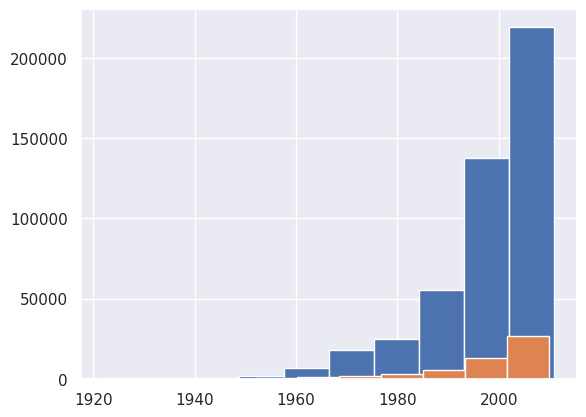

In [ ]:
plt.hist(y_train)
plt.hist(y_test);

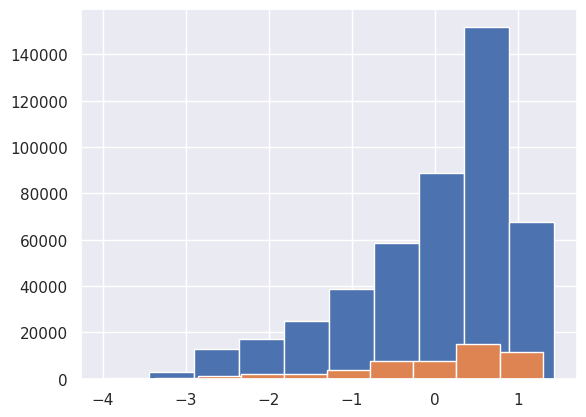

In [ ]:
plt.hist(y_train_tr)
plt.hist(y_test_tr);

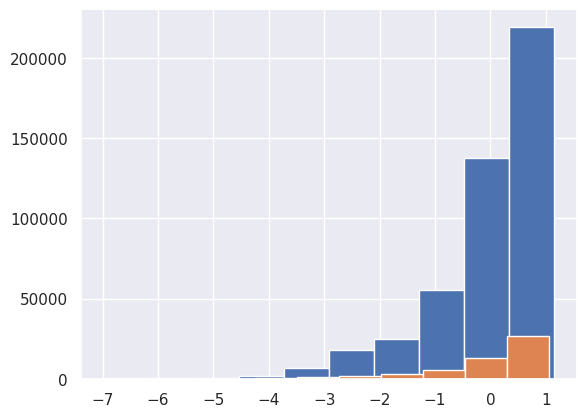

In [ ]:
plt.hist(y_train_std)
plt.hist(y_test_std);

In [ ]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_tr, dtype=torch.float32).to(device).view(-1, 1)
y_test_tensor = torch.tensor(y_test_tr, dtype=torch.float32).to(device).view(-1, 1)

feature_dim = X_train_tensor.size()[1]

In [ ]:
# model creating

class MyNetworkMonster(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.activation = nn.ReLU()

        self.hidden_1 = nn.Linear(feature_dim, 120)
        self.dropout_1 = nn.Dropout(p=0.5)

        self.hidden_2 = nn.Linear(120, 120)
        self.dropout_2 = nn.Dropout(p=0.5)

        self.hidden_3 = nn.Linear(120, 120)
        self.dropout_3 = nn.Dropout(p=0.5)

        self.output = nn.Linear(120, 1)

    def forward(self, x):
        x = self.hidden_1(x)
        x = self.activation(x)
        x = self.dropout_1(x)

        x = self.hidden_2(x)
        x = self.activation(x)
        x = self.dropout_2(x)

        x = self.hidden_3(x)
        x = self.activation(x)
        x = self.dropout_3(x)

        y_pred = self.output(x)
        return y_pred

In [ ]:
n_epochs = 42
batch_size = 64
lr = 0.0002

train_set = tuple(zip(X_train_tensor, y_train_tensor))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = tuple(zip(X_test_tensor, y_test_tensor))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = MyNetworkMonster(feature_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)
criterion = nn.MSELoss()

TypeError: unsupported operand type(s) for ** or pow(): 'MSELoss' and 'float'

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    One epoch step

    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    epoch_train_mse = 0
    epoch_test_mse = 0

    # training loop
    model.train()
    for index, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        y_pred = model(x)
        loss = criterion(y, y_pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # преобразовать предсказания на батче из нормированной формы в обычную
        y_pred_numpy = torch.tensor(pt.inverse_transform(y_pred.detach().to('cpu'))) # если использовать мой подход с батч-агрегацией метрики, то лучше переписать трансформер на torch операции с gpu
        y_numpy = torch.tensor(pt.inverse_transform(y.detach().to('cpu')))

        mse_unnormilized = criterion(y_numpy, y_pred_numpy)
        epoch_train_mse += mse_unnormilized

        if (index + 1) % int(len(train_loader)/5) == 0: # print 5-ти промежуточных метрик батчей
            rmse_to_print = mse_unnormilized ** 0.5
            print(f"batch {index + 1}, train RMSE loss : {rmse_to_print}")

    # testing loop
    model.eval()
    for index, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
      with torch.no_grad():
          test_pred = model(x)
          y_pred_numpy = torch.tensor(pt.inverse_transform(test_pred.to('cpu')))
          y_numpy = torch.tensor(pt.inverse_transform(y.to('cpu')))
          test_loss = criterion(y_numpy, y_pred_numpy)
          epoch_test_mse += test_loss

    rmse_train = (epoch_train_mse/len(train_loader))**0.5
    rmse_test = (epoch_test_mse/len(test_loader))**0.5

    logger['train'].append(rmse_train.item())
    logger['test'].append(rmse_test.item())

    print('<>')
    print(f"EPOCH SCORE => train rmse: {rmse_train} test rmse: {rmse_test}")
    print('-'*70)


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    m = model.to('cpu')
    with torch.no_grad():
        test_pred = m(X_test_tensor.to('cpu'))
        y_pred_numpy = torch.tensor(pt.inverse_transform(test_pred))
        y_numpy = torch.tensor(pt.inverse_transform(y_test_tensor.to('cpu')))
        test_loss = criterion(y_numpy, y_pred_numpy)

    rmse_test = test_loss**0.5
    print(rmse_test) # side-effect принт RMSE метрики

    return y_pred_numpy


In [ ]:
logger = {
    'train': [],
    'test': [],
}

In [ ]:
for ep in range(n_epochs):
    print(f"EPOCH #{ep+1}")

    train(model, optimizer, criterion, train_loader, test_loader)

EPOCH #1


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 11.890317321943588
batch 2898, train RMSE loss : 10.926086149267626
batch 4347, train RMSE loss : 7.603995987445794
batch 5796, train RMSE loss : 8.140756363588999
batch 7245, train RMSE loss : 8.712999875097873


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: nan test rmse: 9.041179075153538
----------------------------------------------------------------------
EPOCH #2


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.4373574989161
batch 2898, train RMSE loss : 10.348429089999419
batch 4347, train RMSE loss : 10.144732464341049
batch 5796, train RMSE loss : 10.396470774307119
batch 7245, train RMSE loss : 7.297153598380008


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 9.148742046214908 test rmse: 8.928538446449716
----------------------------------------------------------------------
EPOCH #3


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.18867545408234
batch 2898, train RMSE loss : 9.888975794446175
batch 4347, train RMSE loss : 9.07304376121459
batch 5796, train RMSE loss : 11.432756103408396
batch 7245, train RMSE loss : 10.916486841177276


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 9.057275116730755 test rmse: 8.943747277355481
----------------------------------------------------------------------
EPOCH #4


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.555545945340587
batch 2898, train RMSE loss : 6.823824527280098
batch 4347, train RMSE loss : 10.533538150627544
batch 5796, train RMSE loss : 10.44084318837904
batch 7245, train RMSE loss : 9.846077010705786


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 9.009874601805276 test rmse: 8.90493248848375
----------------------------------------------------------------------
EPOCH #5


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.543698184995995
batch 2898, train RMSE loss : 8.515349568414303
batch 4347, train RMSE loss : 10.350676043620734
batch 5796, train RMSE loss : 8.413954462573205
batch 7245, train RMSE loss : 7.318545524955829


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.982693666529036 test rmse: 8.87951251121343
----------------------------------------------------------------------
EPOCH #6


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.13452641321262
batch 2898, train RMSE loss : 8.752477305653098
batch 4347, train RMSE loss : 9.707114961734733
batch 5796, train RMSE loss : 8.240237117405478
batch 7245, train RMSE loss : 6.403452365724568


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.952334235080121 test rmse: 8.898852021305308
----------------------------------------------------------------------
EPOCH #7


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.819888837259278
batch 2898, train RMSE loss : 8.476045613674694
batch 4347, train RMSE loss : 10.421484756926793
batch 5796, train RMSE loss : 7.889001409457018
batch 7245, train RMSE loss : 8.247707188104316


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.936991834679953 test rmse: 8.856311270529234
----------------------------------------------------------------------
EPOCH #8


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.514729764805983
batch 2898, train RMSE loss : 8.427764154364352
batch 4347, train RMSE loss : 9.140592946502679
batch 5796, train RMSE loss : 8.748201926249633
batch 7245, train RMSE loss : 8.619341828851711


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.924630488890822 test rmse: 8.838867809393399
----------------------------------------------------------------------
EPOCH #9


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.170314241504801
batch 2898, train RMSE loss : 6.030889712054369
batch 4347, train RMSE loss : 6.139915155883989
batch 5796, train RMSE loss : 7.725146364581835
batch 7245, train RMSE loss : 8.659600359889104


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.908397030768759 test rmse: 8.884842259600589
----------------------------------------------------------------------
EPOCH #10


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.954261657194537
batch 2898, train RMSE loss : 9.83939741612267
batch 4347, train RMSE loss : 8.712032032124664
batch 5796, train RMSE loss : 8.26424458055525
batch 7245, train RMSE loss : 8.588089939427162


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.89043016687761 test rmse: 8.83676054177659
----------------------------------------------------------------------
EPOCH #11


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.589033753179699
batch 2898, train RMSE loss : 7.460648310623897
batch 4347, train RMSE loss : 8.000034156700163
batch 5796, train RMSE loss : 8.71981405897848
batch 7245, train RMSE loss : 6.868546685020061


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.890708269897711 test rmse: 8.849205676375853
----------------------------------------------------------------------
EPOCH #12


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.66666883606271
batch 2898, train RMSE loss : 6.673123232446909
batch 4347, train RMSE loss : 10.188114214947932
batch 5796, train RMSE loss : 6.867726435849541
batch 7245, train RMSE loss : 8.108735356033549


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.880601997209002 test rmse: 8.815319740630583
----------------------------------------------------------------------
EPOCH #13


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.312640854149093
batch 2898, train RMSE loss : 9.420535389772475
batch 4347, train RMSE loss : 8.333812537457923
batch 5796, train RMSE loss : 7.531909947407265
batch 7245, train RMSE loss : 10.676153769028023


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.871204014508587 test rmse: 8.838092386182652
----------------------------------------------------------------------
EPOCH #14


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.172099987042309
batch 2898, train RMSE loss : 7.307076243263218
batch 4347, train RMSE loss : 8.146449313509766
batch 5796, train RMSE loss : 10.615049227957583
batch 7245, train RMSE loss : 9.135822676576169


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.870544599942962 test rmse: 8.815804226719688
----------------------------------------------------------------------
EPOCH #15


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 11.2033654257076
batch 2898, train RMSE loss : 8.097150646576138
batch 4347, train RMSE loss : 6.592329489687767
batch 5796, train RMSE loss : 10.387479215582193
batch 7245, train RMSE loss : 12.209643088816293


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.856590389208325 test rmse: 8.825089783757614
----------------------------------------------------------------------
EPOCH #16


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.215231692713461
batch 2898, train RMSE loss : 6.719779357377482
batch 4347, train RMSE loss : 9.167583698418252
batch 5796, train RMSE loss : 8.894616676196032
batch 7245, train RMSE loss : 11.172681299769888


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.851638225103786 test rmse: 8.827447781083414
----------------------------------------------------------------------
EPOCH #17


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.760691939641037
batch 2898, train RMSE loss : 8.276326992713779
batch 4347, train RMSE loss : 7.557176938357516
batch 5796, train RMSE loss : 8.360624925304148
batch 7245, train RMSE loss : 6.848887460510568


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.854101241578265 test rmse: 8.809127827513272
----------------------------------------------------------------------
EPOCH #18


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.540729955580792
batch 2898, train RMSE loss : 7.185950321481569
batch 4347, train RMSE loss : 6.824649948034457
batch 5796, train RMSE loss : 10.979490956058426
batch 7245, train RMSE loss : 8.000313737256437


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.850207369827565 test rmse: 8.79162526943923
----------------------------------------------------------------------
EPOCH #19


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.379065064224937
batch 2898, train RMSE loss : 8.548249606836116
batch 4347, train RMSE loss : 7.633274726419406
batch 5796, train RMSE loss : 8.27770933578176
batch 7245, train RMSE loss : 9.983263596262068


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.848521959321651 test rmse: 8.773734010679622
----------------------------------------------------------------------
EPOCH #20


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.406589897602748
batch 2898, train RMSE loss : 7.7527610042944275
batch 4347, train RMSE loss : 9.686058049601801
batch 5796, train RMSE loss : 7.4818672047462735
batch 7245, train RMSE loss : 8.508955001009868


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.834599531337886 test rmse: 8.796515316035203
----------------------------------------------------------------------
EPOCH #21


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.257536481297592
batch 2898, train RMSE loss : 7.688840785312352
batch 4347, train RMSE loss : 8.226179917531722
batch 5796, train RMSE loss : 8.636594508604459
batch 7245, train RMSE loss : 7.980490141737464


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.831413465113963 test rmse: 8.825036787052511
----------------------------------------------------------------------
EPOCH #22


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.280539001273872
batch 2898, train RMSE loss : 8.746242692436674
batch 4347, train RMSE loss : 8.951258724475526
batch 5796, train RMSE loss : 9.370593803954137
batch 7245, train RMSE loss : 8.569853746313406


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.828982212895268 test rmse: 8.806251387056061
----------------------------------------------------------------------
EPOCH #23


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.71200046672918
batch 2898, train RMSE loss : 6.380543502144321
batch 4347, train RMSE loss : 7.328594298270024
batch 5796, train RMSE loss : 8.367517687120595
batch 7245, train RMSE loss : 8.599598221533869


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.826813548787053 test rmse: 8.78448888298006
----------------------------------------------------------------------
EPOCH #24


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.459882889185399
batch 2898, train RMSE loss : 7.868865676690105
batch 4347, train RMSE loss : 8.237800275009207
batch 5796, train RMSE loss : 11.839794086673356
batch 7245, train RMSE loss : 6.949131780964273


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.821445248173244 test rmse: 8.799720477253292
----------------------------------------------------------------------
EPOCH #25


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.200201123543112
batch 2898, train RMSE loss : 8.568091946156583
batch 4347, train RMSE loss : 6.469155457317735
batch 5796, train RMSE loss : 12.64791249999248
batch 7245, train RMSE loss : 9.797064946319656


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.825155702231108 test rmse: 8.809576977081605
----------------------------------------------------------------------
EPOCH #26


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.64031141125582
batch 2898, train RMSE loss : 9.099332008807517
batch 4347, train RMSE loss : 9.294748787861792
batch 5796, train RMSE loss : 6.8173347524798205
batch 7245, train RMSE loss : 10.657563758823482


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.81710343042647 test rmse: 8.79155216185834
----------------------------------------------------------------------
EPOCH #27


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.27462816699612
batch 2898, train RMSE loss : 7.771413651861274
batch 4347, train RMSE loss : 5.965022928403486
batch 5796, train RMSE loss : 8.653922478903553
batch 7245, train RMSE loss : 9.894403390485222


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.817594445318381 test rmse: 8.771370714439136
----------------------------------------------------------------------
EPOCH #28


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 10.416188202430657
batch 2898, train RMSE loss : 5.469920429252041
batch 4347, train RMSE loss : 8.03430534436818
batch 5796, train RMSE loss : 7.439565284323494
batch 7245, train RMSE loss : 9.221324520732606


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.81117467898758 test rmse: 8.775746166644762
----------------------------------------------------------------------
EPOCH #29


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.519790129976535
batch 2898, train RMSE loss : 8.024448830705035
batch 4347, train RMSE loss : 7.3572135218335255
batch 5796, train RMSE loss : 7.090886168229665
batch 7245, train RMSE loss : 11.621433674172197


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.810152648744959 test rmse: 8.791279364881406
----------------------------------------------------------------------
EPOCH #30


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.918671250417628
batch 2898, train RMSE loss : 11.818368067099941
batch 4347, train RMSE loss : 10.034577211306669
batch 5796, train RMSE loss : 9.873217638160181
batch 7245, train RMSE loss : 8.803361287376278


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.810414212892757 test rmse: 8.760442362578956
----------------------------------------------------------------------
EPOCH #31


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.660360768086176
batch 2898, train RMSE loss : 8.131527363780839
batch 4347, train RMSE loss : 10.315022264344746
batch 5796, train RMSE loss : 9.719545716492249
batch 7245, train RMSE loss : 7.986458148162574


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.809139018517207 test rmse: 8.78345900288055
----------------------------------------------------------------------
EPOCH #32


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.552835862404805
batch 2898, train RMSE loss : 8.895231547554598
batch 4347, train RMSE loss : 6.556003106963369
batch 5796, train RMSE loss : 8.863660988459705
batch 7245, train RMSE loss : 10.4868923155924


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.806074770592334 test rmse: 8.792869025759645
----------------------------------------------------------------------
EPOCH #33


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.760032740296516
batch 2898, train RMSE loss : 10.82371799871452
batch 4347, train RMSE loss : 8.38678860848676
batch 5796, train RMSE loss : 10.882848496872553
batch 7245, train RMSE loss : 7.65390803374801


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.802228967864343 test rmse: 8.778353483423917
----------------------------------------------------------------------
EPOCH #34


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.345973776643614
batch 2898, train RMSE loss : 9.054260415103967
batch 4347, train RMSE loss : 7.395778327854864
batch 5796, train RMSE loss : 8.148558610389971
batch 7245, train RMSE loss : 6.509713566838182


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.804475786773018 test rmse: 8.771198506451002
----------------------------------------------------------------------
EPOCH #35


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.370056374502319
batch 2898, train RMSE loss : 11.098582206843357
batch 4347, train RMSE loss : 6.13336561479697
batch 5796, train RMSE loss : 12.273809303270022
batch 7245, train RMSE loss : 12.059881812449484


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.8009937756409 test rmse: 8.776040366778759
----------------------------------------------------------------------
EPOCH #36


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.136191787592946
batch 2898, train RMSE loss : 8.906480305289179
batch 4347, train RMSE loss : 8.510893540578298
batch 5796, train RMSE loss : 11.32278446841797
batch 7245, train RMSE loss : 12.391829681462


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.800314183847766 test rmse: 8.79619666347658
----------------------------------------------------------------------
EPOCH #37


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.20452846586051
batch 2898, train RMSE loss : 8.318735808723696
batch 4347, train RMSE loss : 10.267516067720484
batch 5796, train RMSE loss : 10.144239243144877
batch 7245, train RMSE loss : 10.490479929502428


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.793106072466571 test rmse: 8.788556931183825
----------------------------------------------------------------------
EPOCH #38


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.660920077380249
batch 2898, train RMSE loss : 6.615992234949856
batch 4347, train RMSE loss : 7.470826450881535
batch 5796, train RMSE loss : 8.158922513470845
batch 7245, train RMSE loss : 7.981784675162171


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.789296408932923 test rmse: 8.789688605982827
----------------------------------------------------------------------
EPOCH #39


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.140703235249058
batch 2898, train RMSE loss : 8.679704387027934
batch 4347, train RMSE loss : 8.330740437230148
batch 5796, train RMSE loss : 8.184119915409283
batch 7245, train RMSE loss : 6.072946924755674


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.797654002672449 test rmse: 8.79787431262468
----------------------------------------------------------------------
EPOCH #40


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 9.053430507728304
batch 2898, train RMSE loss : 8.943209872710034
batch 4347, train RMSE loss : 7.5845911436903455
batch 5796, train RMSE loss : 7.420722061523991
batch 7245, train RMSE loss : 6.943650065381096


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.795120615335657 test rmse: 8.780514067175158
----------------------------------------------------------------------
EPOCH #41


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 7.787124271930768
batch 2898, train RMSE loss : 8.757129672283567
batch 4347, train RMSE loss : 9.442160223288202
batch 5796, train RMSE loss : 9.00641385826885
batch 7245, train RMSE loss : 9.553890109936265


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.778454314113795 test rmse: 8.780979314197776
----------------------------------------------------------------------
EPOCH #42


  0%|          | 0/7246 [00:00<?, ?it/s]

batch 1449, train RMSE loss : 8.628474238755146
batch 2898, train RMSE loss : 9.272571328242146
batch 4347, train RMSE loss : 8.741224284701422
batch 5796, train RMSE loss : 8.502130997425542
batch 7245, train RMSE loss : 8.807100779446182


  0%|          | 0/807 [00:00<?, ?it/s]

<>
EPOCH SCORE => train rmse: 8.786930918854553 test rmse: 8.76755708114571
----------------------------------------------------------------------


In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]